<a href="https://colab.research.google.com/github/aaron-philip/FDTD-Laplacian/blob/main/Heat_Laplacian_NIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pswpswpsw/nif.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pswpswpsw/nif.git to /tmp/pip-req-build-bbzh9663
  Running command git clone -q https://github.com/pswpswpsw/nif.git /tmp/pip-req-build-bbzh9663
     |████████████████████████████████| 238 kB 5.1 MB/s 
  Created wheel for NIF: filename=NIF-1.0.1-py3-none-any.whl size=2946550 sha256=c772f2ed48d49e6f26ffda9204e4fc9be16b75187ead15684a40262a66a3437a
  Stored in directory: /tmp/pip-ephem-wheel-cache-57fnx98n/wheels/88/ba/9a/716e4d26db4b1364836a1dd0bfa96bb8d89b1e67736b0da3fb
Successfully built NIF


In [2]:
import tensorflow as tf
import nif
import numpy as np
from scipy.integrate import solve_ivp
import time
import logging
import contextlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from nif.optimizers import centralized_gradients_for_optimizer
import math

1 Physical GPUs, 1 Logical GPUs


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Simplifying assumptions: Fixed size (also in FD Solver), Heat is only in one small 'sphere', thermal diffusitivity is constant
def on_grid(x,y,z, grid):
    nx, ny, nz = grid.shape
    if x <= nx-1 and x >= 0 and y <= ny-1 and y >= 0 and z <= nz-1 and z >= 0:
        return True
    else:
        return False

def gen_state0(x,y,z, T):
    state0 = np.zeros([32, 32, 32])
    adjacent_loc = [(x,y,z), # centered point
                    (x+1,y,z), (x,y+1,z), (x,y,z+1), 
                    (x-1,y,z),(x,y-1,z), (x,y,z-1)]
    for loc in adjacent_loc:
        if on_grid(*loc, state0):
            state0[loc] = T
    return state0

state1 = gen_state0(5,5,5, 20)
print(state1[5,6,5])

20.0


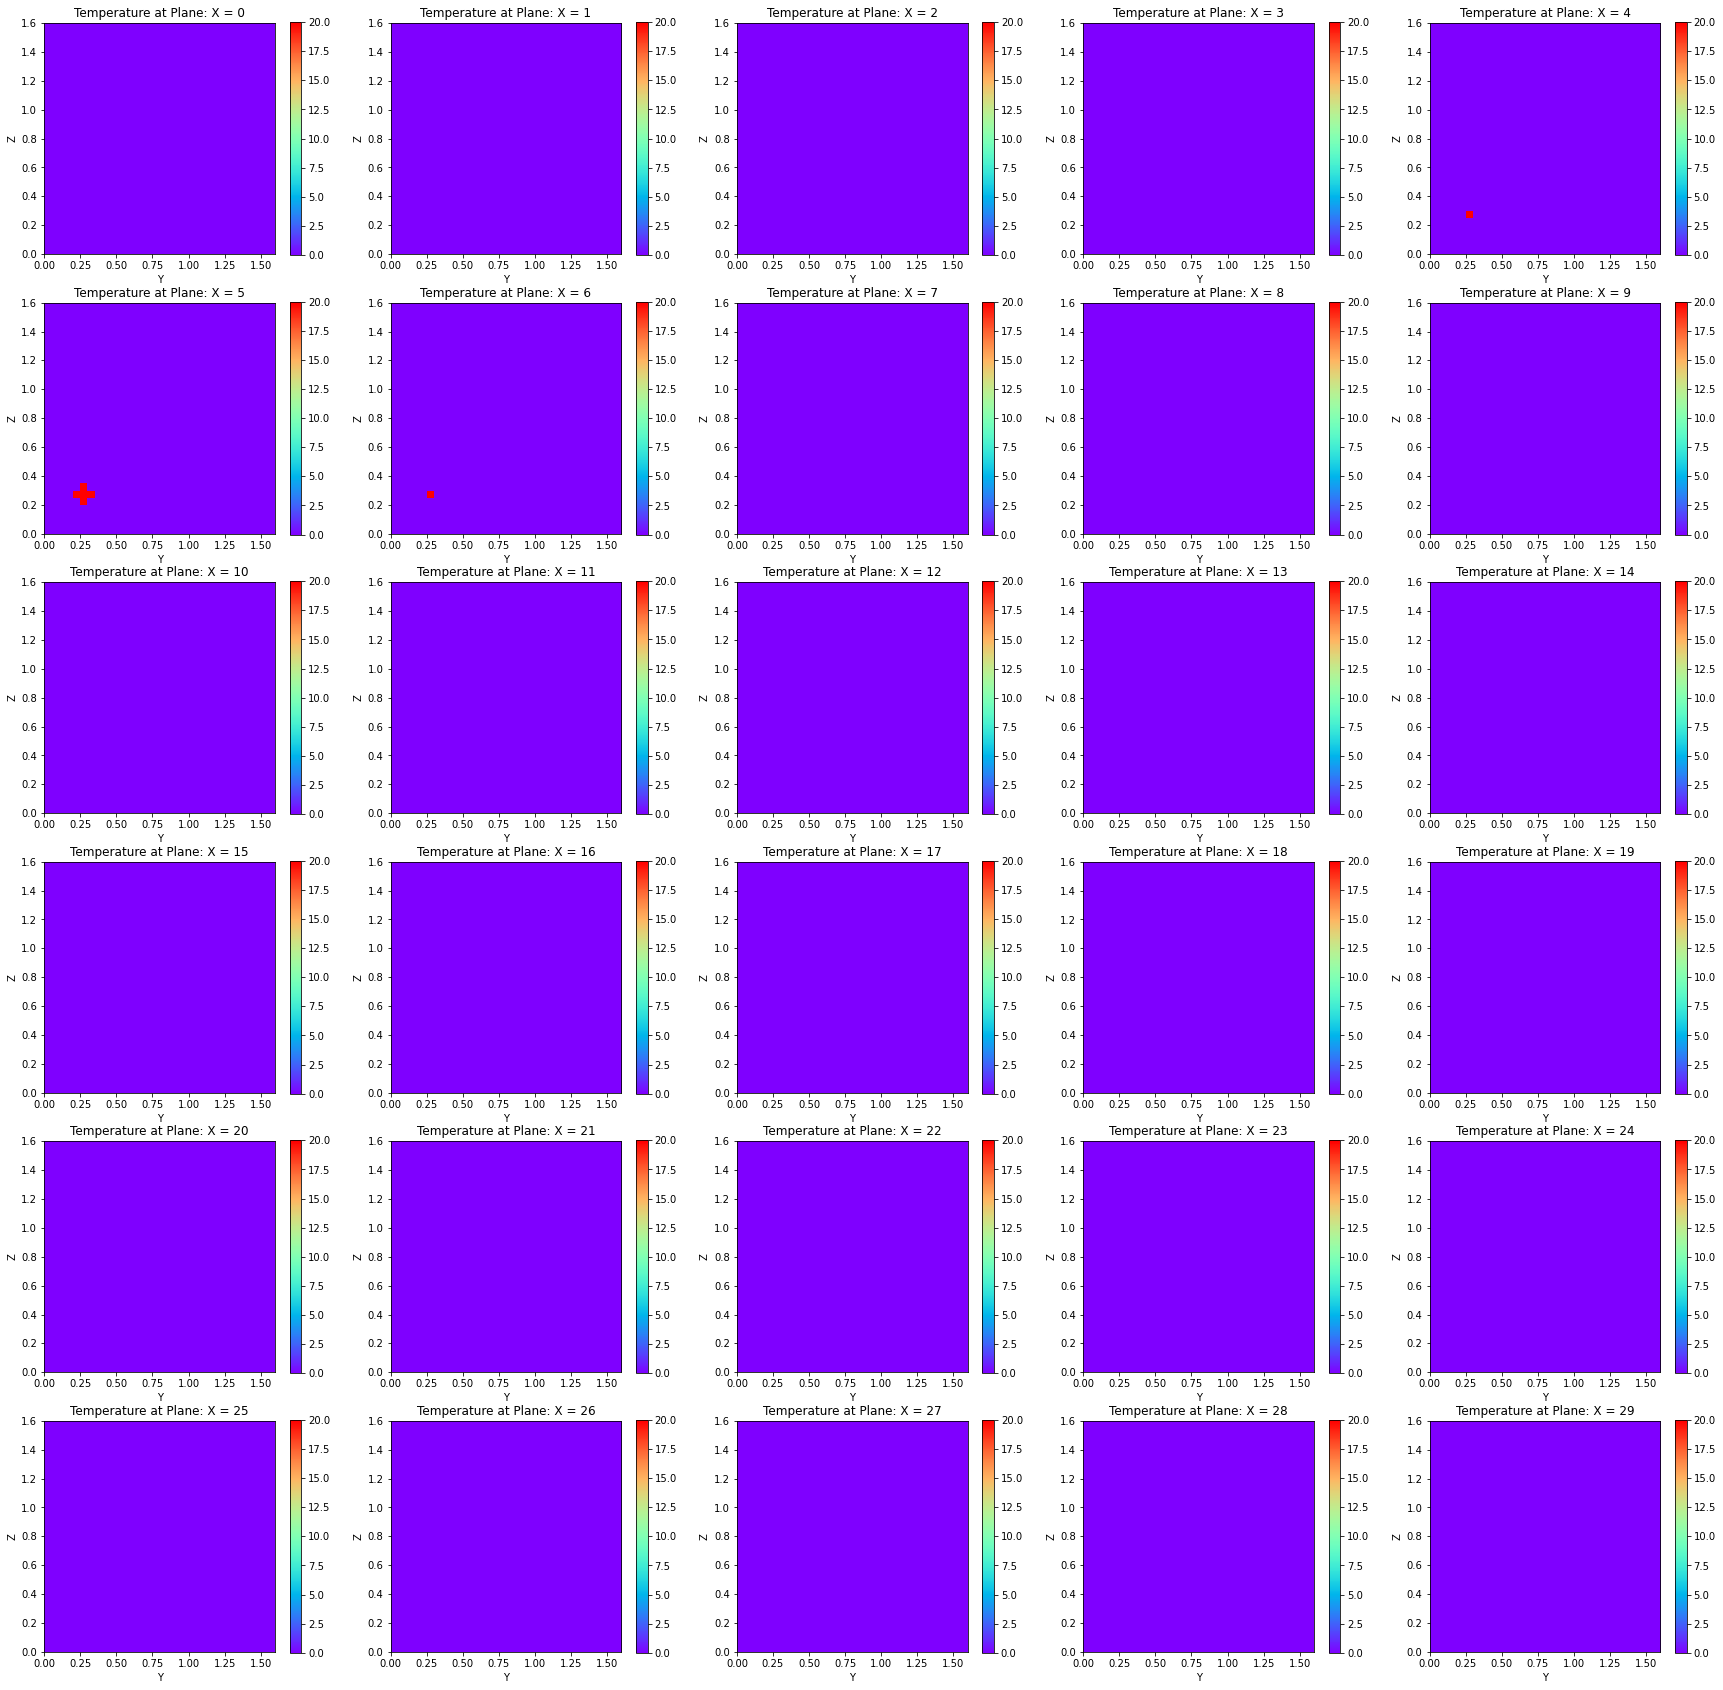

In [5]:
dl = 0.05

# will plot a slice of the mesh of the temperature at a plane normal to the x-axis 
def plotxSlice(mesh, dl, x_slice, multiple=False):
    if multiple:     
        pos = plt.imshow(mesh[x_slice],vmin=np.min(mesh), vmax = np.max(mesh), 
                extent =[0, dl*np.shape(mesh[x_slice])[0], 0, dl*np.shape(mesh[x_slice])[1]],
                interpolation='nearest', cmap='rainbow', origin ='lower')
    else:
        pos = plt.imshow(mesh[x_slice],
                extent =[0, dl*np.shape(mesh[x_slice])[0], 0, dl*np.shape(mesh[x_slice])[1]],
                interpolation='nearest', cmap='rainbow', origin ='lower')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title("Temperature at Plane: X = %s" % x_slice)
    plt.colorbar(pos)

# prints out various slices of our mesh to see the initial temperature distribution
plt.subplots(figsize=(30,30))
for i in range(0,30):
    plt.subplot(6,5,i+1)
    plotxSlice(state1, dl, i, multiple=True) 

In [6]:
def alpha(t,x,y,z, dl, TD=False):
    if TD: 
        x *= dl
        y *= dl
        z *= dl
        alpha = np.exp(-t*x*y) - np.cos(z**2) * np.sin(z)
    # uniform option
    else: 
        alpha = 0.05
    return alpha

# finite difference for 2nd order central difference
def FD_2nd(vector, dl):
    vxx = [0]
    for i in range(np.shape(vector)[0]-2):
        vxx.append((vector[i+2]+vector[i]-2*vector[i+1])/(dl**2))
    vxx.append(0)
    return np.array(vxx)

#calculates FD 2nd partial derivatives for the mesh in each dimension
def uxx(mesh,dl):
    nx, ny, nz = np.shape(mesh)
    uxx = np.zeros([nx, ny, nz]) 
    for y in range(ny):
        for z in range(nz):
            vector = []
            for i in range(nx):
                vector.append(mesh[i][y][z])
            vector = np.array(vector)
            FD = FD_2nd(vector, dl)
            for x in range(nx): 
                uxx[x][y][z] = FD[x]
    return uxx

def uyy(mesh,dl):
    nx, ny, nz = np.shape(mesh)
    uyy = np.zeros([nx, ny, nz]) 
    for x in range(nx):
        for z in range(nz):
            vector = []
            for i in range(ny):
                vector.append(mesh[x][i][z])
            vector = np.array(vector)
            FD = FD_2nd(vector, dl)
            for y in range(ny): 
                uyy[x][y][z] = FD[y]
    return uyy
def uzz(mesh, dl):
    nx, ny, nz = np.shape(mesh)
    uzz = np.zeros([nx, ny, nz])
    for x in range(nx):
        for y in range(ny):
            uzz[x][y] = FD_2nd(mesh[x][y], dl)
    return uzz

def ut(t, mesh, nx, ny, nz, dl):
    mesh = np.reshape(mesh, (nx, ny, nz))
    
    x = np.arange(nx).astype('f')
    x = np.repeat(x, ny*nz)
    y = np.arange(ny).astype('f')
    y = np.repeat(y, nx*nz)
    z = np.arange(nz).astype('f')
    z = np.repeat(z, nx*ny)
    
    ut = alpha(t, x, y, z, dl)*(uxx(mesh, dl)+uyy(mesh,dl)+uzz(mesh,dl))
    return np.reshape(ut, (-1))



In [7]:
st = time.time()
t_eval = np.arange(0,1, 0.01)
sol = solve_ivp(ut, t_span=(t_eval[0], t_eval[-1]), y0=np.reshape(state1, (-1)), t_eval=t_eval,args=(32, 32, 32, dl))
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 112.12606310844421 seconds


(32768, 100)


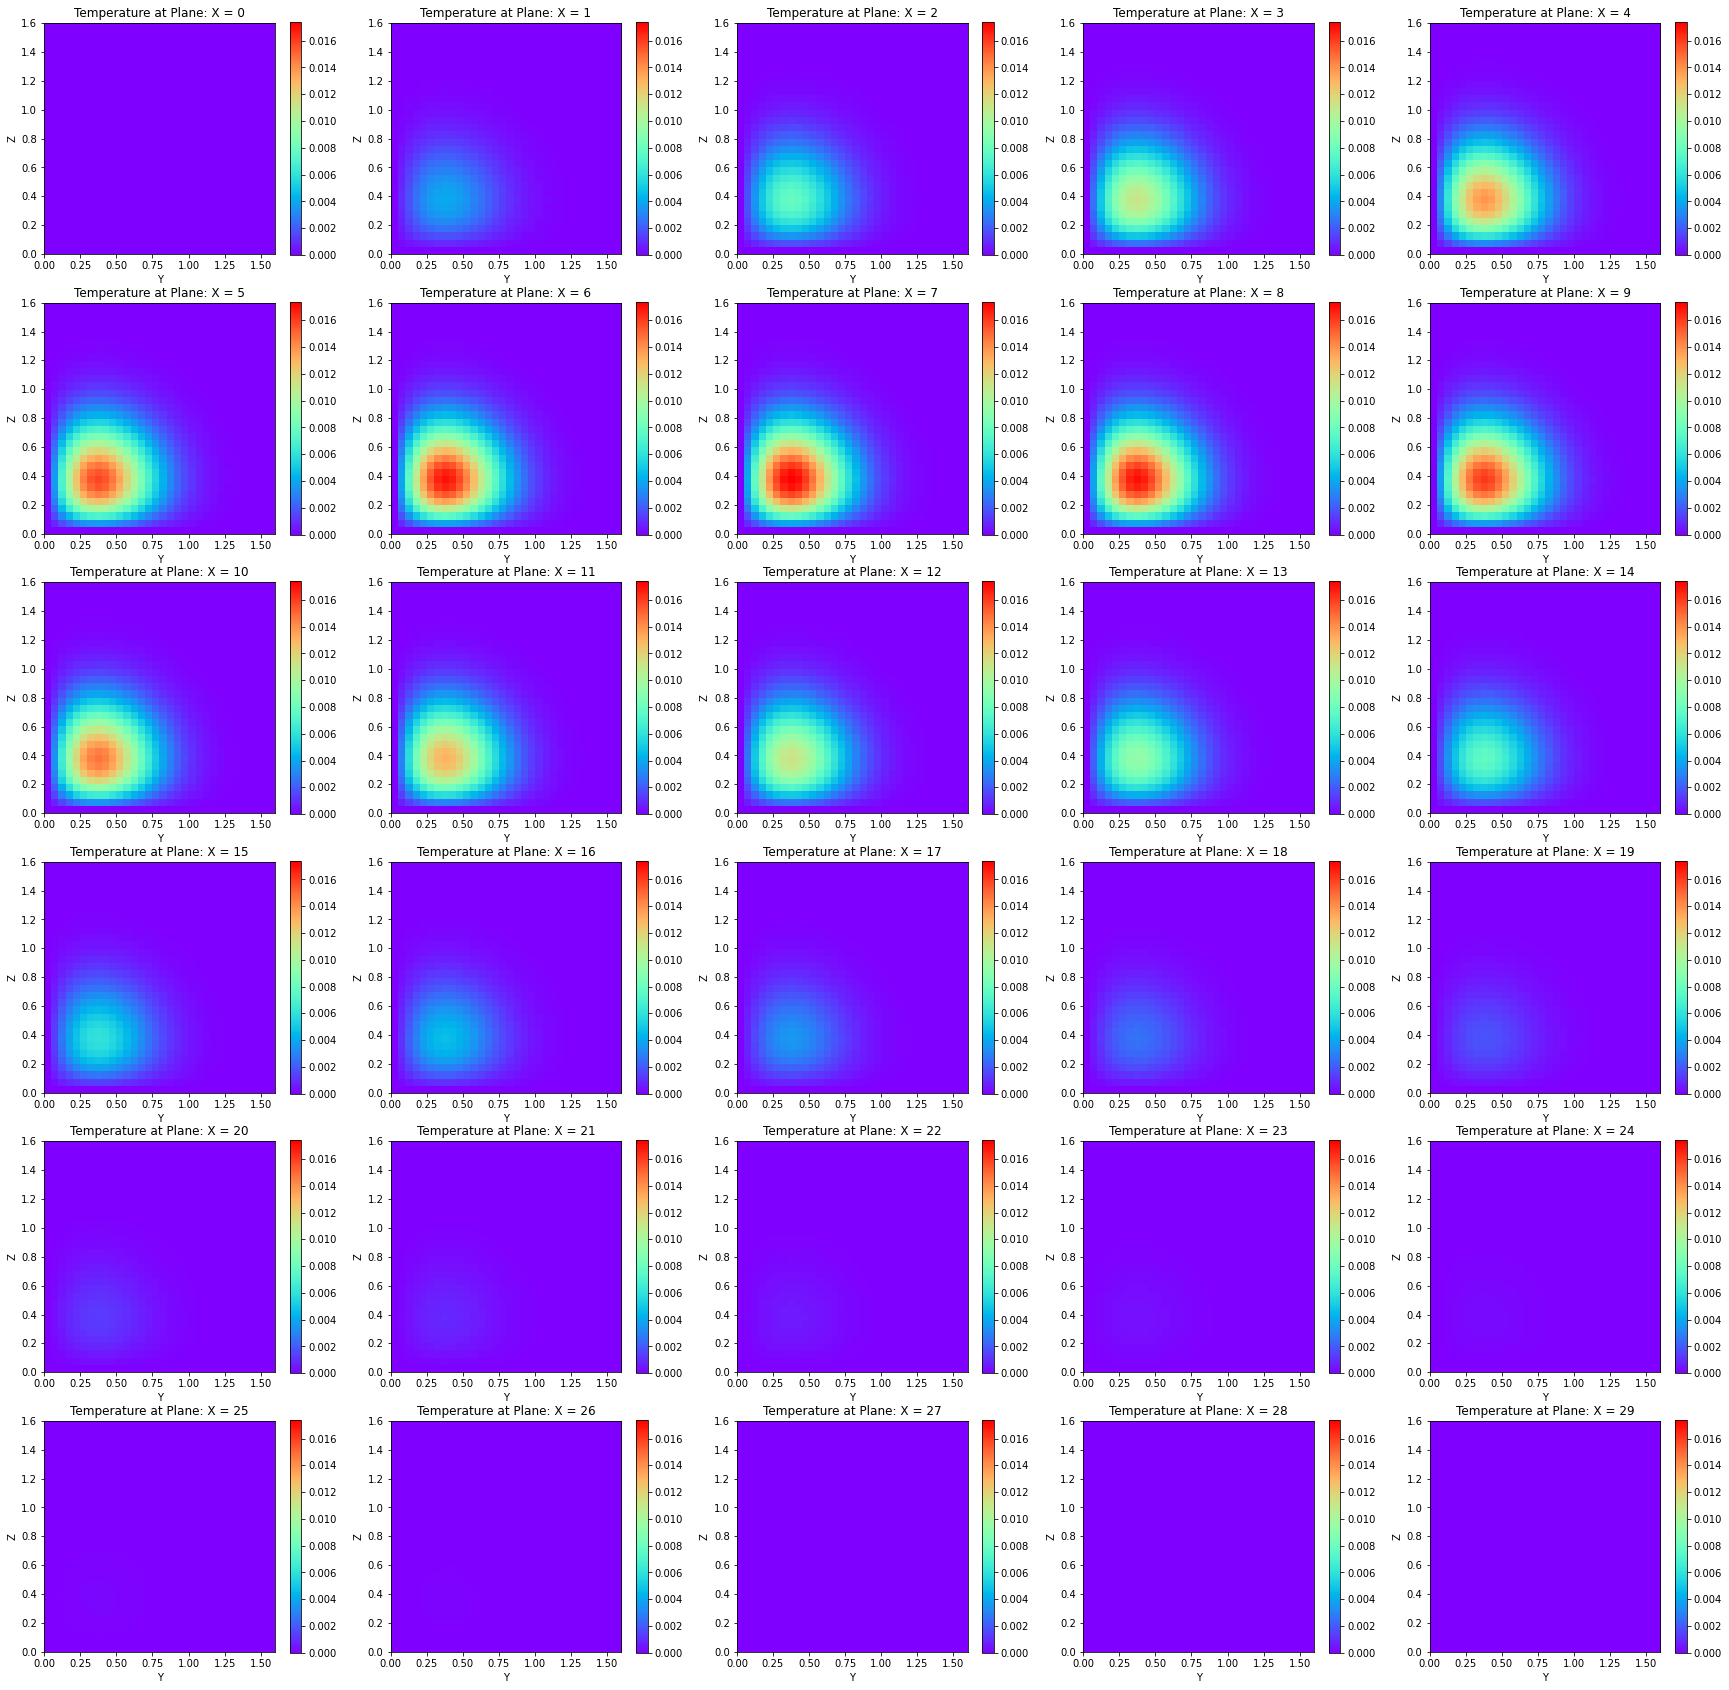

In [8]:
print(np.shape(sol.y))
plt.subplots(figsize=(30,30))
y = np.reshape(sol.y.T[99], (32,32,32))
for i in range(0,30):
    plt.subplot(6,5,i+1)
    plotxSlice(y, dl, i, multiple=True)